In [1]:
import torch
import torchvision

import pandas as pd
import numpy as np

# Seed

In [2]:
seed_number = 44

torch.manual_seed(seed_number)
torch.cuda.manual_seed(seed_number)
torch.cuda.manual_seed_all(seed_number) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed_number)
#random.seed(seed_number)

# Data Load

In [3]:
df = pd.read_csv('./seoul_107_air_quality_2001_2021.csv')

print(df.shape)
df.head()

(7266, 7)


,dt,so2,no2,co,o3,pm10,pm2.5
0,2001-01-01,0.003542,0.03384,0.6543,0.004250,71.30,55.53
1,2001-01-02,0.001583,0.02759,0.5957,0.006084,428.00,160.60
2,2001-01-03,0.002125,0.02650,0.4458,0.006958,90.80,43.80
3,2001-01-04,0.003708,0.02870,0.5330,0.007416,76.94,42.10
4,2001-01-05,0.005165,0.05063,1.1580,0.000458,98.06,69.75


In [4]:
df.dtypes

dt        object
so2      float64
no2      float64
co       float64
o3       float64
pm10     float64
pm2.5    float64
dtype: object

In [5]:
df['dt'] = pd.to_datetime(df['dt'])
df.dtypes

dt       datetime64[ns]
so2             float64
no2             float64
co              float64
o3              float64
pm10            float64
pm2.5           float64
dtype: object

In [6]:
df_train = df[df['dt'].dt.year < 2019]
df_test  = df[df['dt'].dt.year >= 2019]

print(df_train.shape)
print(df_test.shape)

(6184, 7)
(1082, 7)


In [7]:
X = df_train[['so2','no2','co','o3', 'pm10']].values
y = df_train['pm2.5'].values

X_test = df_test[['so2','no2','co','o3', 'pm10']].values
y_test = df_test['pm2.5'].values

print(X.shape, y.shape)
print(X_test.shape, y_test.shape)

(6184, 5) (6184,)
(1082, 5) (1082,)


# Normalization

In [8]:
X_max = np.max(X, axis=0)
X_min = np.min(X, axis=0)

X      = (X      - X_min) / (X_max - X_min + 1e-10)
X_test = (X_test - X_min) / (X_max - X_min + 1e-10)

In [9]:
print(np.max(X), np.min(X))
print(np.max(X_test), np.min(X_test))

0.999999999999913 0.0
1.2018348605476532 0.0


# Data organize (sequence)

In [10]:
sequence_length = 4

In [11]:
def make_sequence(data, sequence_length):
    data_seq = []
    for i in range(len(data)-sequence_length):
        data_seq.append(data[i:i+sequence_length])
            
    data_seq = np.stack(data_seq, axis=0)    
    return data_seq

In [12]:
X_seq = make_sequence(X, sequence_length=4)
y_seq = make_sequence(y, sequence_length=4)
X_test = make_sequence(X_test, sequence_length=4)
y_test = make_sequence(y_test, sequence_length=4)

print(X_seq.shape)
print(y_seq.shape)
print(X_test.shape)
print(y_test.shape)

(6180, 4, 5)
(6180, 4)
(1078, 4, 5)
(1078, 4)


# Split data

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_seq, y_seq, test_size=0.2, random_state=seed_number)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(4944, 4, 5) (4944, 4)
(1236, 4, 5) (1236, 4)


# Data loader

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

X_train = torch.FloatTensor(X_train).to(device=device)
X_valid = torch.FloatTensor(X_valid).to(device=device)
X_test  = torch.FloatTensor(X_test).to(device=device)

y_train = torch.FloatTensor(y_train).to(device=device)
y_valid = torch.FloatTensor(y_valid).to(device=device)
y_test  = torch.FloatTensor(y_test).to(device=device)

cpu


In [15]:
train_ds = torch.utils.data.TensorDataset(X_train, y_train)
valid_ds = torch.utils.data.TensorDataset(X_valid, y_valid)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=128, shuffle=False)

# Model (many to many)

In [16]:
class Net(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_layer, sequence_length):
        super(Net, self).__init__()
        
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_layer = n_layer
        self.sequence_length = sequence_length
        
        # https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
        self.RNN = torch.nn.RNN(
            n_input, n_hidden, n_layer, batch_first=True
        )
        
        self.fully_connected_layer = torch.nn.Linear(n_hidden, 1)
        
    def forward(self, xb):
        h_init = torch.zeros(self.n_layer, xb.size()[0], self.n_hidden)
        out, _ = self.RNN(xb, h_init)
        
        out_seq = []
        for i in range(sequence_length):
            out_ = self.fully_connected_layer(out[:,i,:])
            out_seq.append(out_)
        out_seq = torch.stack(out_seq, dim=1)
        return out_seq

In [17]:
model = Net(
    n_input=5,
    n_hidden=64,
    n_layer=2,
    sequence_length=sequence_length,
).to(device)
print(model)

Net(
  (RNN): RNN(5, 64, num_layers=2, batch_first=True)
  (fully_connected_layer): Linear(in_features=64, out_features=1, bias=True)
)


# Cost function

In [18]:
criterion = torch.nn.MSELoss()

# Optimizer

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training

In [20]:
import time 

is_train = True
epoch, early_stopping = 0, 0
train_loss_history, valid_loss_history = [], []

while is_train:
    start = time.time()
    train_loss, train_count = 0., 0.
    epoch += 1
    early_stopping += 1
    
    for xb, yb in train_loader:
        prediction = model(xb)
        loss = criterion(prediction[:,:,0], yb)
        train_loss += loss.item()*len(yb)
        train_count += len(yb)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    with torch.no_grad():
        valid_loss = 0
        valid_count = 0.
        
        for xb, yb in valid_loader:
            prediction = model(xb)
            valid_loss += criterion(prediction[:,:,0], yb)*len(yb)
            valid_count += len(yb)
        
    train_loss /= train_count
    valid_loss /= valid_count    
    
    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    
    if min(valid_loss_history) == valid_loss:
        early_stopping = 0
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_loss,
        }, './saved_model.pt')
        
    if early_stopping == 15:
        is_train = False
            
    print(f"======== Epoch {epoch} =======")
    print(f"Loss => train:{train_loss:.5f}, valid:{valid_loss:.5f}, Elapsed time => {time.time()-start:.3f} sec")
    print("=======================================\n")

======== Epoch 1 =======
Loss => train:1158.97876, valid:1096.89404, Elapsed time => 0.302 sec

======== Epoch 2 =======
Loss => train:935.81264, valid:933.11359, Elapsed time => 0.273 sec

======== Epoch 3 =======
Loss => train:799.00968, valid:813.81964, Elapsed time => 0.279 sec

======== Epoch 4 =======
Loss => train:700.72098, valid:726.83441, Elapsed time => 0.270 sec

======== Epoch 5 =======
Loss => train:627.62643, valid:660.63068, Elapsed time => 0.266 sec

======== Epoch 6 =======
Loss => train:571.92143, valid:608.68195, Elapsed time => 0.282 sec

======== Epoch 7 =======
Loss => train:529.33962, valid:569.48975, Elapsed time => 0.270 sec

======== Epoch 8 =======
Loss => train:497.37507, valid:539.30975, Elapsed time => 0.267 sec

======== Epoch 9 =======
Loss => train:473.52901, valid:516.84222, Elapsed time => 0.289 sec

======== Epoch 10 =======
Loss => train:456.02579, valid:500.46689, Elapsed time => 0.261 sec

======== Epoch 11 =======
Loss => train:443.51961, valid:

# Learning Curve

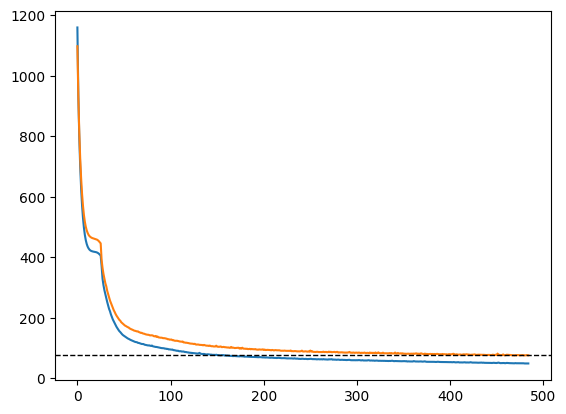

In [21]:
import matplotlib.pyplot as plt 

plt.plot(train_loss_history)
plt.plot(valid_loss_history)
plt.axhline(y=min(valid_loss_history), color='black', linestyle='--', linewidth=1)
plt.show()

# Load best model

In [22]:
checkpoint = torch.load('./saved_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

print(epoch, loss.item())

470 74.82512664794922


# Evaluation

In [23]:
prediction = model(X_test)
loss = criterion(prediction[:,:,0], y_test)

print(f"loss: {loss:.5f}")

loss: 44.45799


In [24]:
for i in range(sequence_length):
    loss = criterion(prediction[:,i,0], y_test[:,i])
    print(f"loss of the {i+1}th sequence: {loss:.5f}")

loss of the 1th sequence: 47.35857
loss of the 2th sequence: 44.47178
loss of the 3th sequence: 42.14256
loss of the 4th sequence: 43.85908


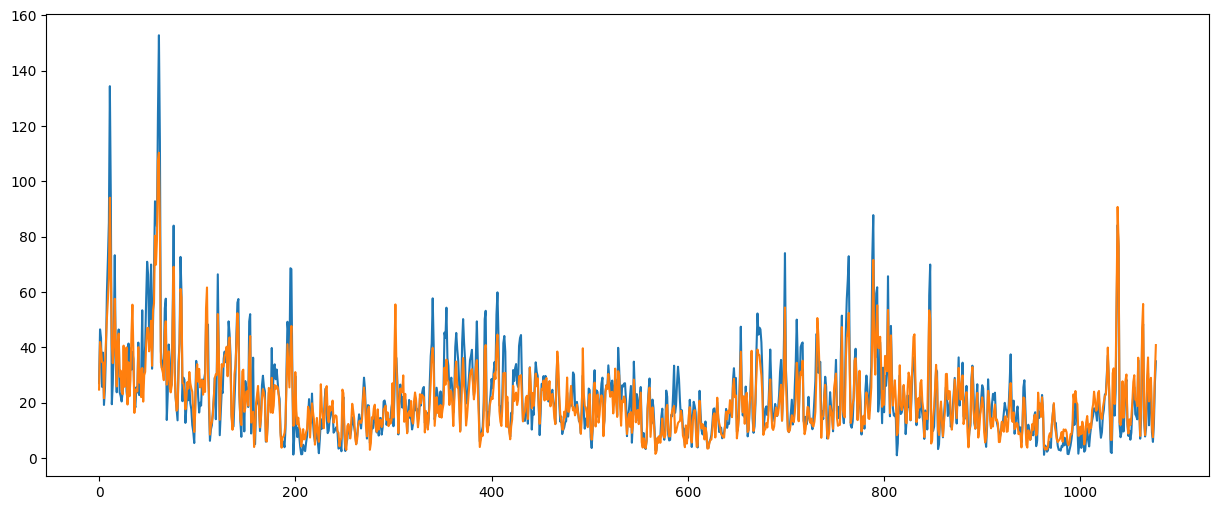

In [25]:
plt.figure(figsize=(15,6))
#plt.plot(y_test[:,2].detach().numpy())
plt.plot(df_test['pm2.5'].iloc[2:-(sequence_length-2)].values)
plt.plot(prediction[:,2,0].detach().numpy())
plt.show()